# Photonic integrated circuit: ring resonator

## Overview
We simulate small silicon ring resonator coupled to parallel waveguides buried in silica cladding. Compare with [Lumerical example](https://optics.ansys.com/hc/en-us/articles/360042800293-Ring-resonator-getting-started-Design-and-initial-simulation)

## Geometry

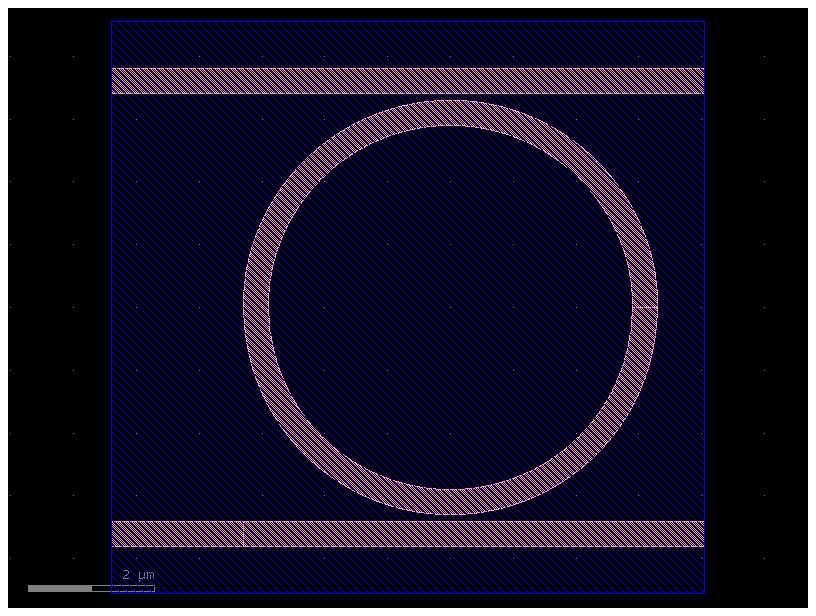

In [18]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Image

# simulation folder
path = os.path.join("runs", "ring")

# length units are arbitrary so long as they are consistent, in this case [um]. everything gets normalized around center wavelength and period at backend.
wavelength = 1.55  # characteristic wavelength [um]
bandwidth = 0.1  # wavelength bandwidth [um]
wavelengths = np.linspace(wavelength - bandwidth / 2, wavelength + bandwidth / 2, 401)

r = 3.1  # radius of ring
w_wg = 0.4  # width of waveguide
gap = 0.1  # gap between waveguide and ring
th = 0.18  # th of waveguide

# gds layers
WG = (1, 0)  # waveguide layer
BBOX = (10, 0)  # bounding box layer

# we create geometry in gdsfactory. alternatively, you can import .gds layout into gdsfactory or .stl bodies directly into ours
# for gdsfactory, we need vertical layer stack. "core" layer is special as mode margins are demarcated from it for defining modal sources and monitors. during 3d meshing lower mesh order layers supplant higher mesh order layers
layer_stack = LayerStack(
    layers={
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=th,
            zmin=0.0,
            material="Si",
            mesh_order=10,
        ),
    }
)

# our default lumi.MATERIALS_LIBRARY lib covers limited range of photonic and PCB materials_library. here we create our own materials_library. `background` is special and tags regions outside any bodies during meshing
materials_library = {
    "Si": lumi.Material(epsilon=12.25),
    "SiO2": lumi.Material(epsilon=2.25),
}
materials_library["background"] = materials_library["SiO2"]

# margins are demarcated from `core` layer
height_port_margin = lateral_port_margin = 0.5
margin = 1.5 * lateral_port_margin
zmargin = 1.5 * height_port_margin
source_port_margin = 1.5 * (w_wg + 2 * lateral_port_margin)

# draw layout in gdsfactory. `gf.components` defaults to layer WG = (1, 0)
c = gf.Component()

dut = c << gf.components.ring(radius=r, width=w_wg, layer=WG)

l_branch = 2 * r + w_wg + source_port_margin + margin
branch_bottom_left = c << gf.components.straight(length=source_port_margin, width=w_wg)
branch_bottom_left.move((-source_port_margin - r - w_wg / 2, -w_wg - gap -r))

branch_bottom_right = c << gf.components.straight(length=l_branch - source_port_margin, width=w_wg)
branch_bottom_right.connect("o1", branch_bottom_left.ports["o2"])

branch_top = c << gf.components.straight(length=l_branch, width=w_wg)
branch_top.move((-source_port_margin - r - w_wg / 2, w_wg + gap + r))

# add ports
c.add_port("o1", port=branch_bottom_right.ports["o1"])
c.add_port("o2", port=branch_bottom_right.ports["o2"])  # thru channel
c.add_port("o3", port=branch_top.ports["o1"])  # drop channel

c << gf.components.bbox(component=c, layer=BBOX, top=margin, bottom=margin)
c.plot()

## Solve

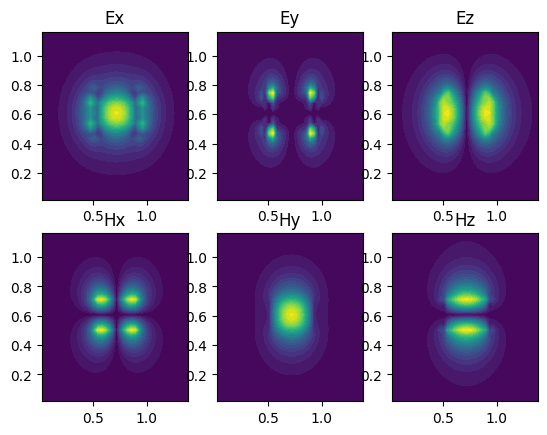

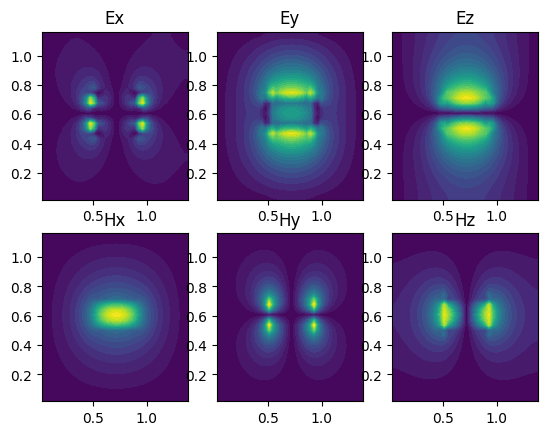

using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\ring
Video generated successfully at runs\ring\simulation.mp4 and runs\ring\simulation.gif!


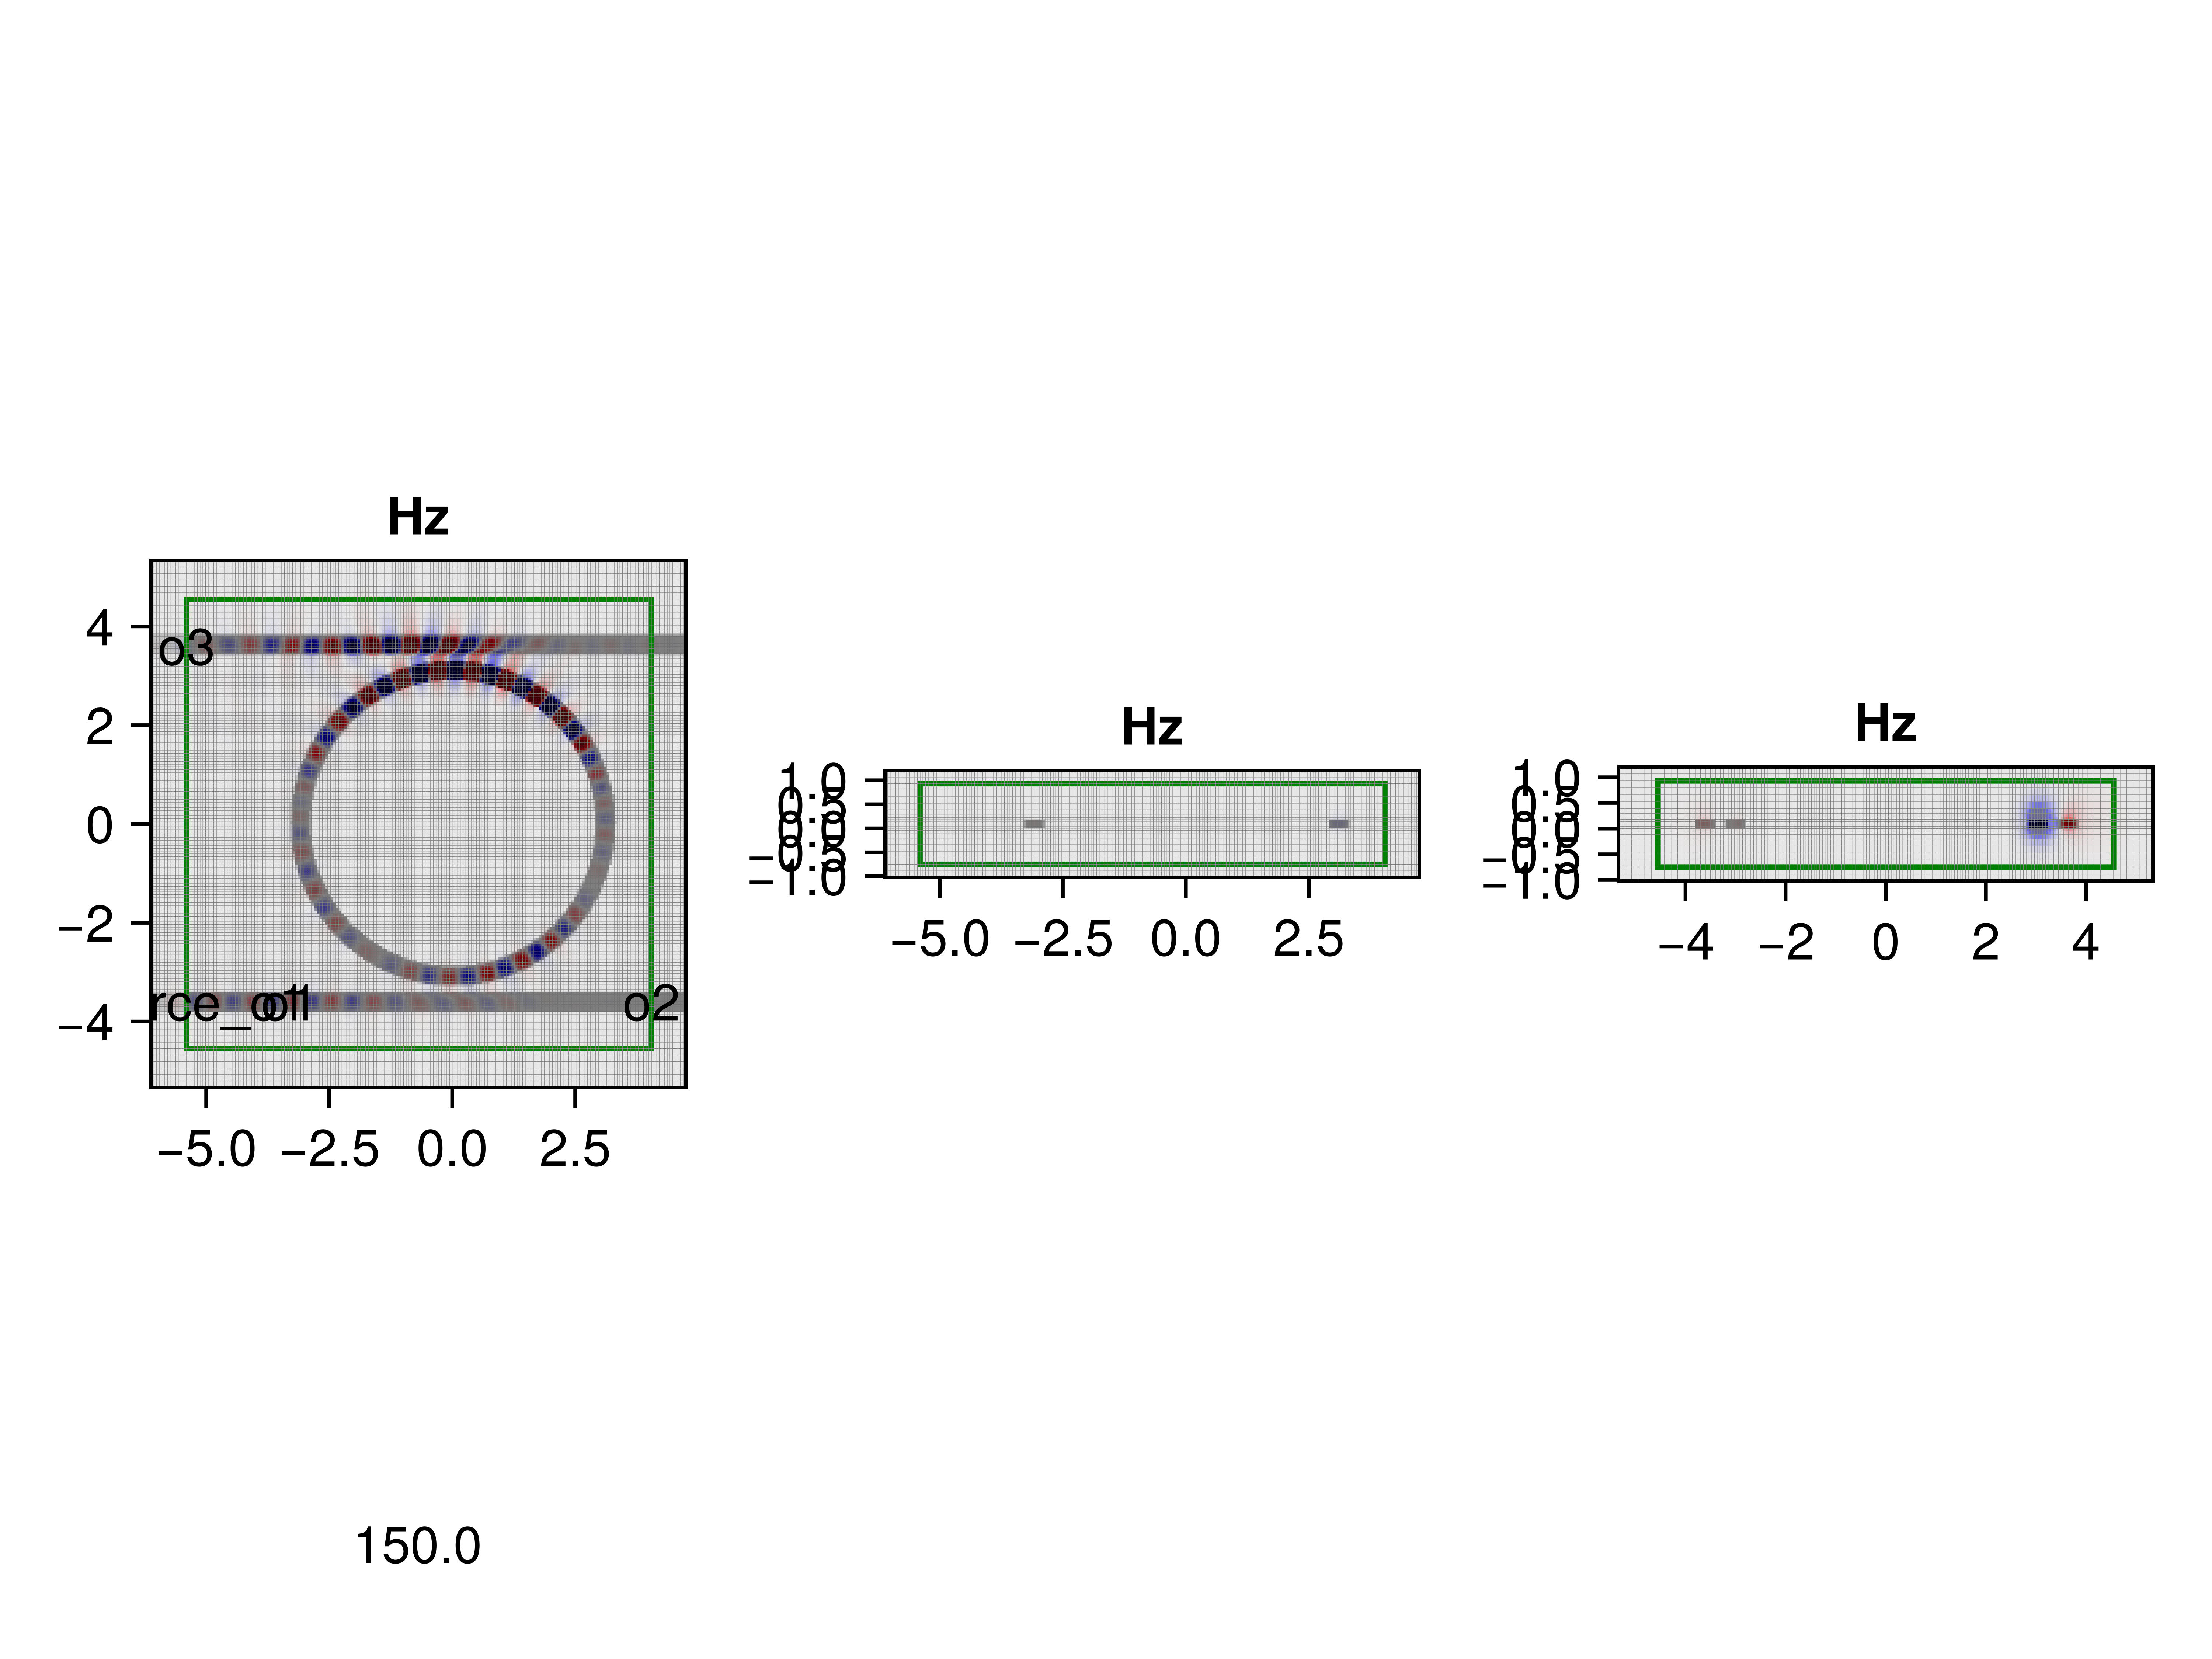

In [ ]:
# source launches `source_port_margin` in front of port. it's bidirectional: the other direction goes into PML. pulse spectrum rolls off gradually past bandwidth limits.
sources = [
    lumi.Source(
        "o1",
        source_port_margin=source_port_margin,
        wavelength=wavelength,
        bandwidth=wavelength/5,
    )
]

modes = [lumi.Mode(wavelength=wavelength)]

kwargs = dict(
    path=path,
    component=c,
    wavelengths=wavelengths,
    sources=sources,
    modes=modes,
    #
    zmin=-zmargin,
    zmax=th + zmargin,
    height_port_margin=height_port_margin,
    lateral_port_margin=lateral_port_margin,
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    #
    gpu="CUDA",  # use GPU acceleration
    nres=8,  # number of grid points per wavelength in material (not vacuum)
    relative_courant=0.95,  # relative Courant number
    relative_pml_depths=[1, 1, 0.3],  # relative PML thes
    Tsim=500,  # max time [periods]
    field_decay_threshold=0.01,  # field energy decay threshold for stopping simulation
    saveat=50,  # save field every n periods for movie
    force=True,  # delete and overwrite existing path
)
lumi.make(**kwargs)
lumi.solve(path)
lumi.plot(path)
display(Image(os.path.join(path, "peak.png")))

## Analysis

loading solution from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\ring


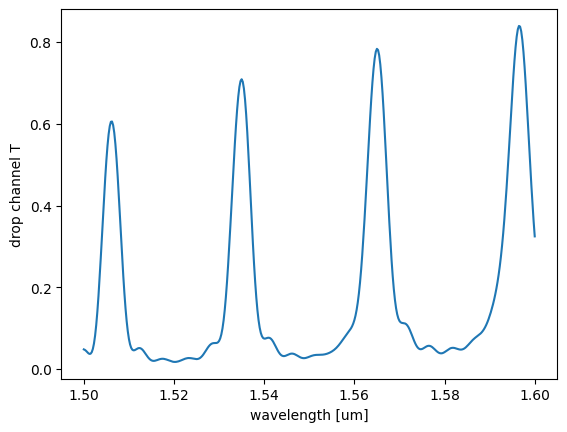

In [20]:
sol = lumi.load(path)
x = wavelengths
y = lumi.query(sol, "T3,1") # wavelength or frequency ordered depending on problem setup
# y = lumi.query(sol, "To3@0,o1@0")
plt.plot(x, y)
plt.xlabel("wavelength [um]")
plt.ylabel("drop channel T")
plt.show()